# Prototype Financial Planner

In [16]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv
from alpaca_trade_api.rest import REST, TimeFrame
import numpy as np
from MCForecastTools import MCSimulation
import json
import re
from utils import find_crypto_value, calc_start_date
from datetime import date, time


load_dotenv()

True

## Part 1 - Personal Finance Planner
---
### Collect Crypto Prices Using the **requests** library

In [17]:
# We will use default crypto values of 1.2 BTC and 5.3 ETH
my_btc = 1.2
my_eth = 5.3

# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/"

# Store and parse crypto data from alternative.me free API
btc_response = requests.get(btc_url)
btc_data = btc_response.json()
eth_response = requests.get(eth_url)
eth_data = eth_response.json()

In [18]:
my_btc_value = find_crypto_value(btc_data)* my_btc
my_eth_value = find_crypto_value(eth_data)* my_eth
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $49231.20
The current value of your 5.3 ETH is $15585.55


### Collect Investments Data Using Alpaca: SPY (stocks) and AGG (bonds)

In [19]:
# Set user share totals for SPY and AGG
my_spy = 50
my_agg = 200

In [20]:
# Set Alpca API key and secret key, then insantiate an API object
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECURITY_KEY")

tradeapi = REST(alpaca_api_key, alpaca_secret_key, api_version='v2')


In [21]:
def get_company(ticker, start, end, tradeapi):
    return tradeapi.get_bars(
        ticker,
        TimeFrame.Day,
        start,
        end
    ).df

In [22]:
# Set start date to five years ago
start_date = calc_start_date(5)
type(start_date)

str

In [23]:

my_df = {
    "SPY":get_company("SPY", start_date, "2022-03-18", tradeapi),
    "AGG":get_company("AGG", start_date, "2022-03-18", tradeapi)
}

In [24]:
full_data = pd.concat(my_df.values(), keys=my_df.keys(), axis="columns")
full_data.head()


SPY                                      \
                             open    high     low    close     volume   
timestamp                                                               
2017-03-21 04:00:00+00:00  237.49  237.61  233.58  233.760  131809275   
2017-03-22 04:00:00+00:00  233.78  234.61  233.05  234.250   97569204   
2017-03-23 04:00:00+00:00  234.01  235.34  233.60  233.940  100410277   
2017-03-24 04:00:00+00:00  234.35  235.04  232.96  233.880  112504853   
2017-03-27 04:00:00+00:00  231.97  233.92  231.61  233.575   87454452   

                                                      AGG                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2017-03-21 04:00:00+00:00      443599  234.853857  107.93  108.27  107.9300   
2017-03-22 04:00:00+00:00      307469  233.932509  108.44  108.54  108.3600   
2017-03-23 04:00:00+00:00      333903  234.388790  108.44  108.51  108.2635   
2017-03-24 04:00:00+00:00      359600  234.080978  108.35  108.51  108.3100   
2017-03-27 04:00:00+00:00      289784  233.041576  108.65  108.71  108.5345   

                                                                    
                            close   volume trade_count        vwap  
timestamp                                                           
2017-03-21 04:00:00+00:00  108.27  2049680       12024  108.175725  
2017-03-22 04:00:00+00:00  108.42  2643641       11111  108.455049  
2017-03-23 04:00:00+00:00  108.45  2071485       10901  108.417635  
2017-03-24 04:00:00+00:00  108.36  3374871       11229  108.398485  
2017-03-27 04:00:00+00:00  108.62  1977292       11112  108.600681

In [25]:
# Pick AGG and SPY close prices
spy_close_price = full_data['SPY'].loc[:,'close'][-1]
agg_close_price = full_data['AGG'].loc[:,'close'][-1]
# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $108.1
Current SPY closing price: $444.52


In [26]:
# Compute the current value of shares
my_spy_value= spy_close_price*my_spy
my_agg_value= agg_close_price*my_agg

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $22226.00
The current value of your 200 AGG shares is $21620.00


In [27]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
savings = {}
savings['crypto'] = my_eth_value+my_btc_value
savings['shares'] = my_agg_value+my_spy_value
# Create DataFrame from dictionary
df_savings = pd.DataFrame.from_dict(savings, orient= 'index')

# Rename column to 'amount'
df_savings.rename(columns={0:'amount'},inplace=True)

# Display savings DataFrame
display(df_savings)

,amount
crypto,64816.751
shares,43846.000


<AxesSubplot:title={'center':'Composition of Personal Savings'}, ylabel='amount'>

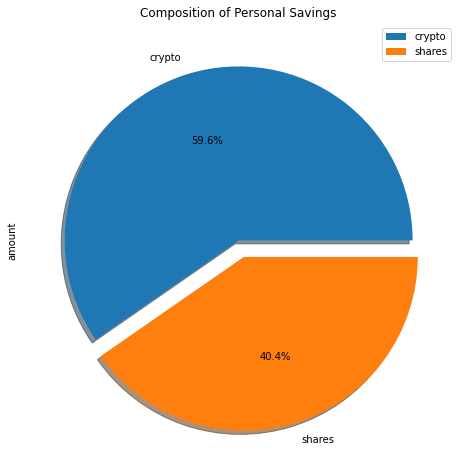

In [28]:
# Plot savings pie chart
df_savings.plot.pie(
    y= 'amount', title= 'Composition of Personal Savings', legend= True,\
    autopct='%1.1f%%', shadow=True, startangle=0,\
    explode = (0, 0.1),\
    figsize = (8, 8)
    )

In [29]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = df_savings['amount'].sum()

# Validate saving health
if total_savings < emergency_fund:
    print(f"Warning: your emergency fund should be {emergency_fund-total_savings} higher")
else:
    print(f"Congratulations! You have adequate savings in case of an emergency!")

Congratulations! You have adequate savings in case of an emergency!


In [40]:
MCSim = MCSimulation(
    full_data,
    weights = [.60, .40],
    num_simulation=1000,
    num_trading_days=(30*252) )

MCSim.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


c:\Users\Laramie\Desktop\FinancialPlanning\FinancialPlanningPrototype\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001069,1.002140,0.998383,1.008810,1.010441,1.006686,1.003947,1.003422,0.996980,1.007064,...,0.989617,1.014768,1.013904,0.991245,1.000464,1.000607,1.014446,0.990499,1.000484,1.005459
2,1.008535,0.997376,1.008019,0.997075,0.997966,1.005544,0.992479,1.006541,0.996608,1.000922,...,0.994547,1.012371,1.014585,0.991578,0.998794,1.005892,1.009182,0.984705,1.002394,1.014750
3,1.009508,0.996007,1.006082,1.008378,0.999101,0.990142,0.990345,0.998077,0.990969,0.992971,...,0.999647,1.012677,1.020884,0.979820,0.991830,1.009928,1.016455,0.994041,0.998898,1.012568
4,1.012976,0.986611,1.006001,1.016368,1.000267,0.989158,0.997515,0.998310,0.991568,1.004789,...,0.996407,1.003231,1.023692,0.976127,0.992613,1.012022,1.021017,0.976135,0.996155,1.018547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,6.438106,7.105747,7.760272,14.823856,10.016405,17.133118,8.496181,59.852599,8.535501,27.062031,...,16.019700,4.843487,13.195293,15.593270,11.321585,3.509096,18.291254,15.839192,13.601620,17.794323
7557,6.459183,7.082499,7.758199,14.932658,9.971148,17.156755,8.479832,60.267313,8.629093,27.290038,...,16.032402,4.810458,13.269786,15.572745,11.352047,3.490260,18.481107,15.838755,13.501857,17.597639
7558,6.497232,7.078150,7.767109,14.884076,10.047064,17.260089,8.533375,60.274061,8.649150,27.055242,...,16.205657,4.795307,13.213064,15.422630,11.364104,3.532622,18.363157,15.910136,13.481819,17.767851
7559,6.577691,7.076853,7.712666,14.686599,9.958532,17.210518,8.465904,60.436646,8.707792,27.169204,...,16.233539,4.826942,13.218275,15.381435,11.464508,3.560323,18.241245,16.017167,13.390892,17.705623


<AxesSubplot:title={'center':'1000 Simulations of Cumulative Portfolio Return Trajectories Over the Next 7560 Trading Days.'}>

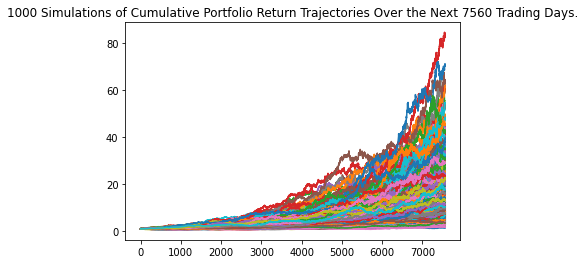

In [41]:
MCSim.plot_simulation()

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 1000 Simulations'}, ylabel='Frequency'>

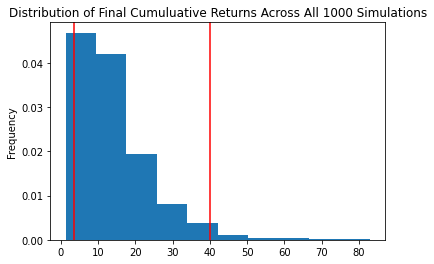

In [42]:
MCSim.plot_distribution()

In [43]:
# Fetch the summary statistics from the sim results
tbl = MCSim.summarize_cumulative_return()

tbl

count           1000.000000
mean              14.491387
std                9.985085
min                1.293336
25%                7.583052
50%               11.636266
75%               18.477028
max               82.969433
95% CI Lower       3.557723
95% CI Upper      40.133972
Name: 7560, dtype: float64

In [61]:
# Set initial investment
initial_investment = 20000

# Calc lower and upper CI total returns
ci_lower_return = round(tbl[8]*initial_investment,2)
ci_upper_return = round(tbl[9]*initial_investment,2)

print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_return} and ${ci_upper_return}")

# going to grab the actual return values for the challenge section
ci_lower = tbl[8]
ci_upper = tbl[9]

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $71154.46 and $802679.44


In [62]:
# Currently, you can only contribute $6,000 dollars per year to an IRA. If our clients are holding retirement funds in a non-ira
# or 401k account, but rather a traditional margin account, we could use the same simulations but we would not have accurate data
# based on taxes, margin expense, etc. Furthermore, commissions are not factored in -- minor but relevant.
# 
# In order to account for these custodial issues, we will create a confidence interval of returns
# based on user-inputs: (1) length of holding period
#                       (2) addition amounts to add to the portfolio,
#                       (3) when the additions are made (quarterly, annual, daily, etc.)
#                       (4) length of holding period
#                       (5) stock/bond mix
# 
# We will then create a confidence interval of monthly withdrawl amounts they can make post retirement
# Average retirement lasts 18 years according to Google -- but we will make it a user input as well


0.11859077105661647